# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [2]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d
from bokeh.io import export_svgs, export_png

# Simulation environment tools
sys.path.append('../..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [3]:
# Network size and where are data files stored
networkSize = 20
folderPath = '../../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

figureFolderPath = "../data/GA_implementation/"+str(networkSize)+"network/"

The following implements some utility functions, not related to main GA

In [4]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [6]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000  16.387995  16.811762  19.863419   9.155982  19.593342   
1        12.146085   0.000000  14.033227  18.507330  13.977076  12.102453   
2        15.951712  17.030096   0.000000   8.476669   9.781827  19.716872   
3        14.229646  12.643793  18.019964   0.000000  15.939453   9.290609   
4        11.552642  14.040350  18.331487   8.001010   0.000000  19.795274   
5        15.705460  11.451442   8.316436  17.507760  16.215286   0.000000   
6         9.830037  11.168722   9.090833  15.031036  10.144259  13.307419   
7         8.209873  18.363482  19.030780  17.720748  11.210923  14.208631   
8         8.545712  18.015558  17.311524  13.445267   9.305929  13.946491   
9        17.049755   9.853105  14.054606  14.893540   8.765405   8.848652   
10       16.426404  19.234910  17.239330   9.239691  18.013164

In [7]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1    1  0.262607   50.470594    7.794744      6.403606       719.931242   
2    2  0.220870   -7.090855   33.912422      8.367632       715.733760   
3    3  0.286208 -135.114698   77.475980      3.253651       655.796890   
4    4  0.113606  -77.740124 -134.244168      2.334244       606.643012   
5    5  0.233183    5.495406  -26.242645      6.359264       670.118480   
6    6  0.080526   19.391791  127.632083      9.867990       639.635829   
7    7  0.087967  148.667245  106.672644      4.204325       609.701528   
8    8  0.368718  142.751062  108.409340      2.769256       673.113827   
9    9  0.462364 -123.944356   -6.172093      7.635774       627.497133   
10  10  0.323470  -47.137733 -104.776102      2.595898       640.448914   
11  11  0.317650  -96.695458  -95.875432      1.169971       670.051147   
12  12  0.293103 

## Create variables

In [12]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)
    
    # Save
    #s.output_backend = "svg"
    #export_svgs(s, filename=figureFolderPath+"CS"+str(row['ID'])+"_chargingFunction.svg")
    
    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [13]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 2
chooseCustomersRandom = True

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[1, 3, 4, 5, 8, 9, 11, 16],
                   [2, 6, 7, 10, 12, 13, 14, 15, 17]]

    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 8 customer/s
Car 1 must visit 9 customer/s


Car 0 must visit customers with ID: [10, 16, 6, 2, 14, 15, 4, 3]
Car 1 must visit customers with ID: [7, 9, 13, 17, 1, 12, 8, 11, 5]


 ## Setup GA

In [14]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [15]:
# %% the algorithm
# Population TODO create function
n = 70
generations = 150

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.4

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 70 individuals
-- Generation 1 --
  Evaluated 36 individuals
  Min -5164430.754130883
  Max -671561.7818511109
  Avg -2264330.4773315093
  Std 1234403.4276332841
Best individual:  [2, 6, 16, 14, 10, 15, 4, 3, -1, 0, 10.0, -1, 18, 16.56218388349065, 436, 11, 8, 9, 12, 13, 17, 5, 1, 7, -1, 0, 10.0, -1, 0, 10.0, 650]
Worst individual:  [6, 3, 10, 15, 2, 16, 14, 4, -1, 0, 10.0, -1, 0, 10.0, 1423, 11, 7, 5, 9, 8, 17, 12, 1, 13, -1, 0, 10.0, -1, 0, 10.0, 417]
-- Generation 2 --
  Evaluated 55 individuals
  Min -3746705.2915019155
  Max -515234.8621585375
  Avg -1319869.751686788
  Std 710659.9557027895
Best individual:  [10, 6, 16, 14, 3, 15, 2, 4, -1, 0, 10.0, -1, 0, 10.0, 628, 12, 13, 1, 11, 17, 8, 7, 9, 5, -1, 0, 10.0, -1, 0, 10.0, 650]
Worst individual:  [2, 16, 4, 6, 14, 3, 15, 10, -1, 0, 10.0, -1, 0, 10.0, 277, 8, 17, 7, 9, 12, 13, 1, 5, 11, -1, 0, 10.0, -1, 0, 10.0, 1244]
-- Generation 3 --
  Evaluated 37 individuals
 

KeyboardInterrupt: 

### Obtain best individual

In [16]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

print('Best individual:\n', bestInd)
print('Best individual fitness:\n', bestInd.fitness)

print('S:\n', S)
print('L:\n', L)
print('x0:\n', x0, '\n')

# Costs
totalTravelTime = 0.0
totalChargingTime = 0.0

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)
    
    reachingTimes = leavingReachingSequences[vehicleId][0]
    leavingTimes = leavingReachingSequences[vehicleId][1]
    spentTimes = leavingTimes - reachingTimes
    
    travelTime = 0.0
    chargingTime = 0.0
    prevLeavingTime = leavingTimes[0]
    for node, reachTime, leaveTime, spentTime in zip(S[vehicleId][1:], reachingTimes[1:], leavingTimes[1:], spentTimes[1:]):
        if networkDict[node].isCustomer():
            travelTime += reachTime - prevLeavingTime
        elif networkDict[node].isChargeStation():
            chargingTime += spentTime
        else:
            travelTime += reachTime - prevLeavingTime
        prevLeavingTime = leaveTime
            
    print('Travel time vehicle', vehicleId, ':', travelTime)
    print('Charging time vehicle', vehicleId, ':', chargingTime, '\n')
    totalTravelTime += travelTime
    totalChargingTime += chargingTime

print('Total travel time:', totalTravelTime)
print('Total charging time:', totalChargingTime)

Best individual:
 [16, 12, 4, 10, 11, 1, 6, 7, 11, 19, 0.04945750038643615, 4, 19, 9.886721300711587, 669.3584843270983, 8, 15, 3, 5, 17, 9, 14, 13, 2, -1, 19, 71.40653006401645, -1, 19, 88.31334988626011, 676.5484480340446]
Best individual fitness:
 (-259.7667259328354,)
S:
 {0: [0, 16, 12, 4, 19, 10, 11, 19, 1, 6, 7, 0], 1: [0, 8, 15, 3, 5, 17, 9, 14, 13, 2, 0]}
L:
 {0: [0, 0, 0, 0, 9.886721300711587, 0, 0, 0.04945750038643615, 0, 0, 0, 0], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
x0:
 {0: 669.3584843270983, 1: 676.5484480340446} 

Travel time vehicle 0 : 120.77272599802086
Charging time vehicle 0 : 8.171453370736117 

Travel time vehicle 1 : 105.21281880510594
Charging time vehicle 1 : 0.0 

Total travel time: 225.9855448031268
Total charging time: 8.171453370736117


### Theta dynamics

In [11]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [12]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Best fitness evolution')
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'

figFitness.output_backend = "svg"
export_svgs(figFitness, filename=figureFolderPath+"fitness.svg")



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Standard deviation of best fitness per generation')
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.left[0].formatter.use_scientific = False

figFitnessStd.output_backend = "svg"
export_svgs(figFitnessStd, filename=figureFolderPath+"fitness_std.svg")

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)


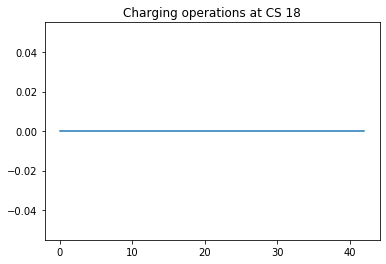

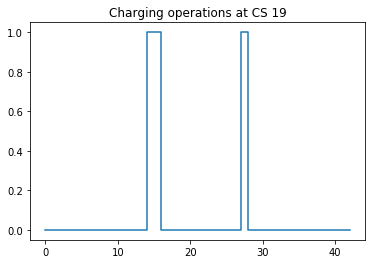

In [13]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(plot_width=600, plot_height=450,
                   title='Time the (vehicle '+str(vehicleID)+')',
                   toolbar_location=None)
    figX2 = figure(plot_width=600, plot_height=450,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(0, 100),
                  toolbar_location=None)
    figX3 = figure(plot_width=600, plot_height=450,
                   title='Payload (vehicle '+str(vehicleID)+')',
                  toolbar_location=None)
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Time of the day (min)'
    figX1.axis.axis_label_text_font_size = '15pt'
    figX1.axis.major_label_text_font_size = '13pt'
    figX1.title.text_font_size = '15pt'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    figX2.axis.axis_label_text_font_size = '15pt'
    figX2.axis.major_label_text_font_size = '13pt'
    figX2.title.text_font_size = '15pt'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Payload (ton)'
    figX3.axis.axis_label_text_font_size = '15pt'
    figX3.axis.major_label_text_font_size = '13pt'
    figX3.title.text_font_size = '15pt'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k
        
    # Save
    export_png(figX1, filename=figureFolderPath+"x1_vehicle"+str(vehicleID)+".png")
    
    export_png(figX2, filename=figureFolderPath+"x2_vehicle"+str(vehicleID)+".png")
    
    export_png(figX3, filename=figureFolderPath+"x3_vehicle"+str(vehicleID)+".png")   
    
    
    # Show
    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure()
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.show()


In [14]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 34535.26496887207 ms
